In [161]:
%run data_loader.py

Data loaded


## Step 1: Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [162]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.container import Container
import itertools
import math

In [163]:
file_base_name = "data/BBC News {}.csv"
test_data = pd.read_csv(file_base_name.format("Test"))
train_data = pd.read_csv(file_base_name.format("Train"))

In [164]:
print(train_data.info())
print(train_data.describe())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None
         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [165]:
print(test_data.info())
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [166]:
solution = pd.read_csv("data/BBC News Sample Solution.csv")
solution.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics


In [167]:
# Extracting labels
labels = train_data["Category"].unique().tolist()
labels

['business', 'tech', 'politics', 'sport', 'entertainment']

In [168]:
train_data.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

In [169]:
def remove_0_tags_for_histograms(ax_container:Container):
    ind = np.where(ax_container.datavalues>0)[0]    
    ax_container.datavalues = ax_container.datavalues[ind]
    ax_container.patches = [ax_container.patches[i] for i in ind]
    return ax_container

def add_histogram_values(ax:plt.Axes):
    [ax.bar_label(remove_0_tags_for_histograms(b)) for b in ax.containers]

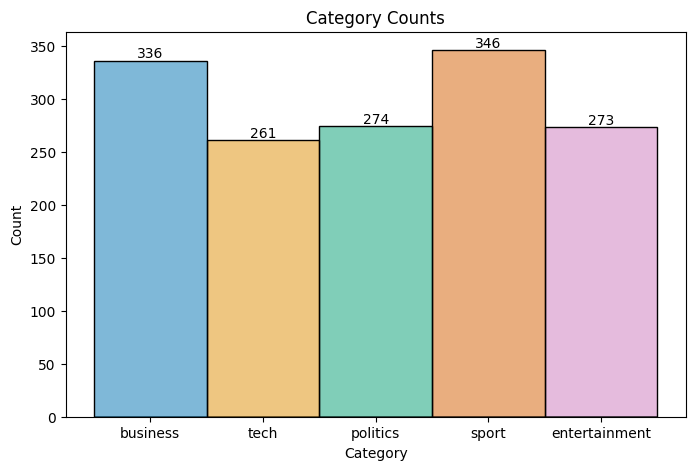

In [170]:
fig, ax = plt.subplots(figsize=(8, 5))
ax2 = sns.histplot(
    data = train_data,
    x = 'Category',
    hue = 'Category',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Category Counts')

add_histogram_values(ax)

In [171]:
train_data['text multiplicity'] = train_data.groupby('Text')['Text'].transform('count').astype(str) 


C:\Users\OM-FI\AppData\Local\Temp\ipykernel_19376\2609365779.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax2 = sns.histplot(


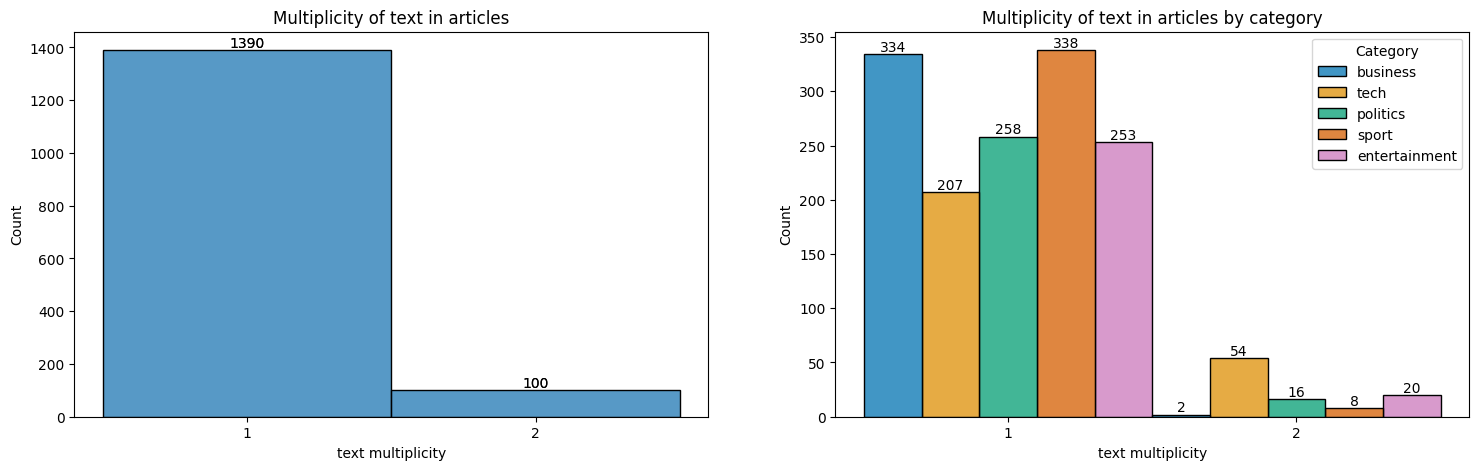

In [172]:
fig, ax = plt.subplots(ncols=2,figsize=(18, 5))

# Histogram showing repeated text multiplicity in training dataframe
ax2 = sns.histplot(
    ax = ax[0],
    data = train_data,
    x='text multiplicity',
    palette = 'colorblind',
    multiple = 'dodge',
    legend = True,
    ).set(
        title = 'Multiplicity of text in articles')
add_histogram_values(ax[0])
# Same histogram, by Category
ax2 = sns.histplot(
    ax = ax[1],
    data = train_data,
    x='text multiplicity',
    hue = 'Category',
    palette = 'colorblind',
    multiple = 'dodge',
    legend = True,
    ).set(
        title = 'Multiplicity of text in articles by category')
add_histogram_values(ax[0])
add_histogram_values(ax[1])

In [173]:
# Check how many categories are in each repeated text group
print(train_data[train_data['text multiplicity']!='1'].groupby('Text', as_index=False)['Category'].nunique().head())
print("--"*30,"\n")
print('The maximum number of different categories assigned to repeated texts is: {}'.format(\
train_data[train_data['text multiplicity']!='1'].groupby('Text')['Category'].nunique().max()))

                                                Text  Category
0  ask jeeves joins web log market ask jeeves has...         1
1  aviator  creator  in oscars snub the man who s...         1
2  blind student  hears in colour  a blind studen...         1
3  bortolami predicts dour contest italy skipper ...         1
4  britons fed up with net service a survey condu...         1
------------------------------------------------------------ 

The maximum number of different categories assigned to repeated texts is: 1


In [174]:
print("--Before filtering--")
print(train_data.groupby("Category").count().iloc[:,0])
print("--After filtering--")
train_data.drop_duplicates(subset="Text",keep="first", inplace=True)
print(train_data.groupby("Category").count().iloc[:,0])

--Before filtering--
Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: ArticleId, dtype: int64
--After filtering--
Category
business         335
entertainment    263
politics         266
sport            342
tech             234
Name: ArticleId, dtype: int64


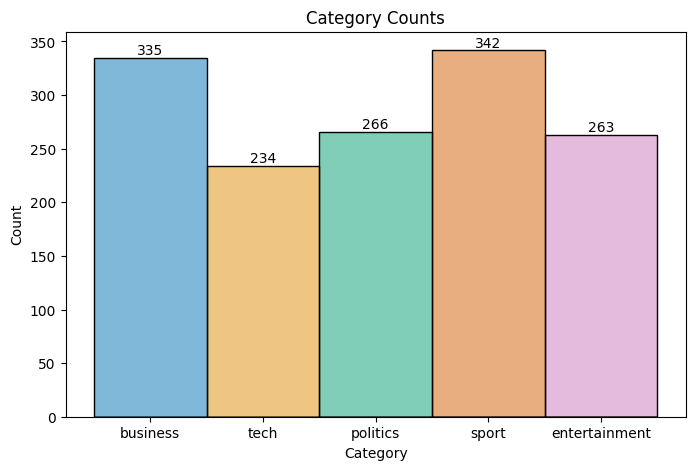

In [190]:
fig, ax = plt.subplots(figsize=(8, 5))
ax2 = sns.histplot(
    data = train_data,
    x = 'Category',
    hue = 'Category',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Category Counts')

add_histogram_values(ax)

Mean text length: 2234.2618055555554
Min length: 501
Max length: 18387


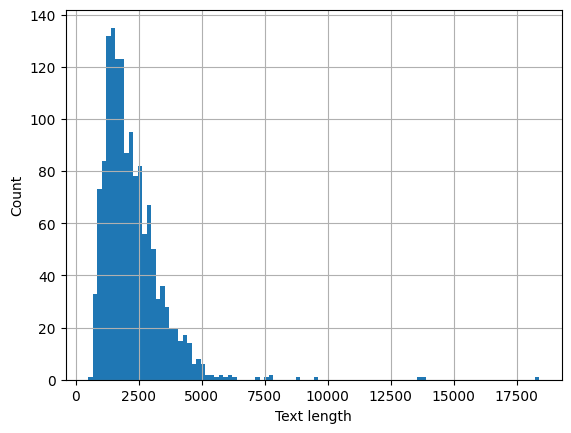

In [175]:
text_lenght = train_data["Text"].apply(lambda x: len(x))
text_lenght.hist(bins=100)
plt.ylabel("Count")
plt.xlabel("Text length")
print(f"Mean text length: {text_lenght.mean()}\nMin length: {text_lenght.min()}\nMax length: {text_lenght.max()}")
plt.show()

--After filtering--


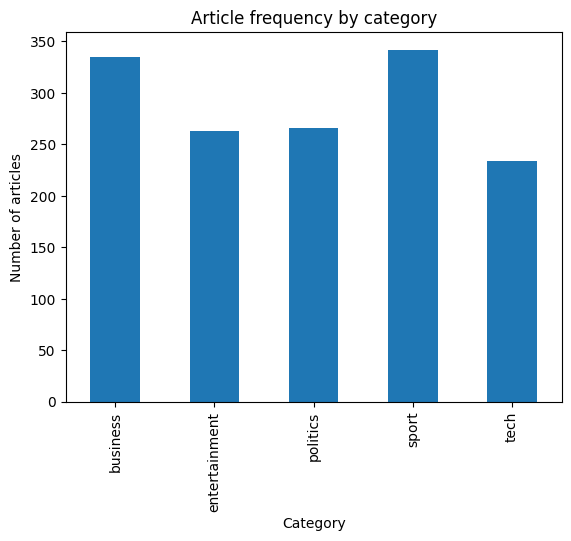

Category
business         335
entertainment    263
politics         266
sport            342
tech             234
Name: ArticleId, dtype: int64
Mean:  288.0


In [176]:
print("--After filtering--")
count_by_labels = train_data.groupby("Category").count().iloc[:,0]
count_by_labels.plot.bar(title="Article frequency by category", ylabel="Number of articles")
plt.show()
print(count_by_labels)
mean_count = count_by_labels.mean()
print("Mean: ", mean_count)

In [177]:
print("\nOriginal train shape:", train_data.shape)
print("The mean number of category is ", train_data["Category"].value_counts().mean())
print(train_data["Category"].value_counts())


Original train shape: (1440, 4)
The mean number of category is  288.0
Category
sport            342
business         335
politics         266
entertainment    263
tech             234
Name: count, dtype: int64


In [178]:
# mean_count = int(mean_count)
# print(f"New max {mean_count}")

# def filter_by_mean(group: pd.DataFrame):
#     return group.sample(n = min(len(group), mean_count), random_state=42).reset_index(drop =True)

# train_data = train_data.groupby("Category").apply(filter_by_mean).reset_index(drop=True)

# print("\nNew train shape:", train_data.shape)
# print("The mean number of category is ", train_data["Category"].value_counts().mean())
# print(train_data["Category"].value_counts())

Mean text length: 2234.2618055555554
Min length: 501
Max length: 18387


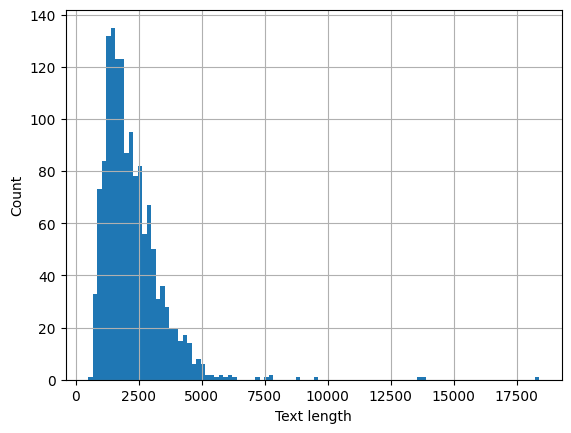

In [179]:
text_lenght = train_data["Text"].apply(lambda x: len(x))
text_lenght.hist(bins=100)
plt.ylabel("Count")
plt.xlabel("Text length")
print(f"Mean text length: {text_lenght.mean()}\nMin length: {text_lenght.min()}\nMax length: {text_lenght.max()}")
plt.show()

In [180]:
def extract_tifd(data:pd.DataFrame, corpus = train_data["Text"]):
    vector = TfidfVectorizer()
    vector.fit(corpus)
    matrix = vector.transform(data["Text"])
    return matrix, vector

train_matrix, train_vector = extract_tifd(train_data)
print("Train shape: ", train_matrix.shape)

test_matrix = train_vector.transform(test_data["Text"])
print(test_data["Text"].shape)
print("Test shape: ", test_matrix.shape)

Train shape:  (1440, 24746)
(735,)
Test shape:  (735, 24746)


(1, 24746) (1, 24746)


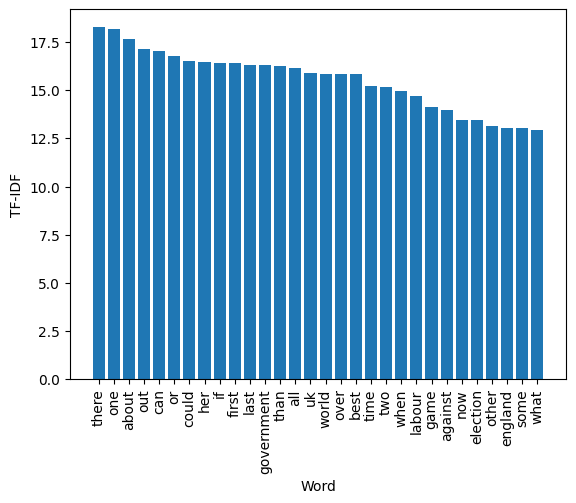

In [181]:
train_featured_names = train_vector.get_feature_names_out().reshape(1,-1)

train_word_count = train_matrix.sum(axis=0).reshape(1,-1)
print(train_featured_names.shape, train_word_count.shape)
trainIndex = np.argsort(train_word_count)[0,::-1]

#Plot highest leverage words
n_to_plot = 30
start = 50

trainPlotNames = train_featured_names[0, trainIndex][0, start : start + n_to_plot].tolist()
trainPlotTFIDF = train_word_count[0, trainIndex][0, start : start + n_to_plot][0,:].tolist()[0]

plt.bar(trainPlotNames,trainPlotTFIDF)
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("TF-IDF")
plt.show()

(1, 29421) (1, 29421)


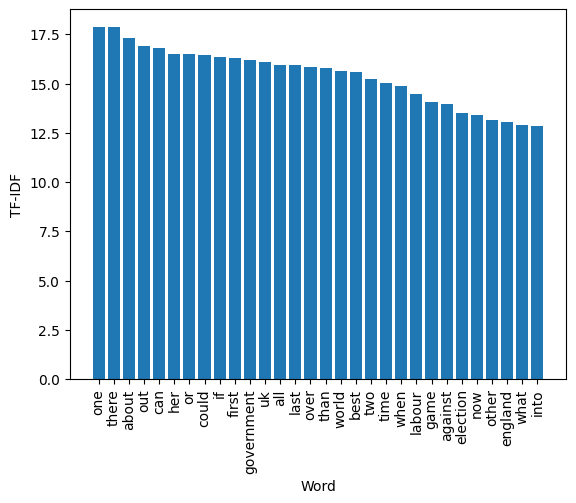

In [182]:
# tfid_weights_train, tfid_vectorizer_train = train_matrix, train_vector
corpus = train_data["Text"].to_list()+ test_data["Text"].to_list()
tfid_weights_train, tfid_vectorizer_train = extract_tifd(train_data, corpus)
train_featured_names = tfid_vectorizer_train.get_feature_names_out().reshape(1,-1)

train_word_count = tfid_weights_train.sum(axis=0).reshape(1,-1)
print(train_featured_names.shape, train_word_count.shape)
trainIndex = np.argsort(train_word_count)[0,::-1]

#Plot highest leverage words
n_to_plot = 30
start = 50

trainPlotNames = train_featured_names[0, trainIndex][0, start : start + n_to_plot].tolist()
trainPlotTFIDF = train_word_count[0, trainIndex][0, start : start + n_to_plot][0,:].tolist()[0]

plt.bar(trainPlotNames,trainPlotTFIDF)
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("TF-IDF")
plt.show()

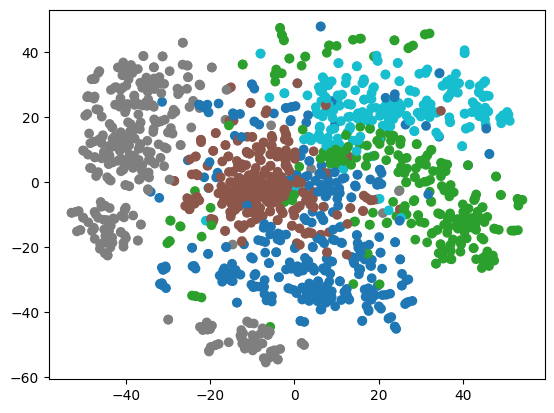

In [183]:
tsne = TSNE(n_components=2, random_state=42, init="random")

tsne_train = tsne.fit_transform(tfid_weights_train)
plt.scatter(tsne_train[:, 0], tsne_train[:, 1], c=train_data['Category'].astype('category').cat.codes, cmap='tab10')
plt.show()

## Step 2: Building and training models

In [184]:
def label_permute_compare(ytdf,yp):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    """
    y_true = np.array(ytdf).reshape(-1)
    uniq_labels = np.unique(y_true)
    perm = itertools.permutations(range(len(uniq_labels)))
    best_p, best_acc = None, 0
    for p in perm:
        p_label_map = {label: int_label for label, int_label in zip(uniq_labels, p)}
        p_labels = np.array([p_label_map[label] for label in y_true])
        acc = np.mean(p_labels == yp)
        if acc > best_acc:
            best_p = {num: l for num, l in zip(p, uniq_labels)}
            best_acc = acc
    return best_p, best_acc

In [185]:
nmf = NMF(train_data["Category"].nunique(), random_state = 42, init = 'nndsvd', beta_loss = "frobenius", max_iter= 1000)
nmf.fit(tfid_weights_train)

NMF(init='nndsvd', max_iter=1000, n_components=5, random_state=42)

In [186]:
y_pred = np.array([np.argmax(yi_pred) for yi_pred in nmf.transform(tfid_weights_train)])

In [187]:
label_map, acc = label_permute_compare(train_data["Category"], y_pred)
print("Train Accuracy:", acc)

Train Accuracy: 0.8743055555555556


In [188]:
tfid_weights_test = tfid_vectorizer_train.transform(test_data["Text"])

y_pred = np.array([np.argmax(yi_pred) for yi_pred in nmf.transform(tfid_weights_test)])
label_map, acc = label_permute_compare(solution["Category"], y_pred)
print("Train Accuracy:", acc)

Train Accuracy: 0.22448979591836735


In [189]:
print(len(test_data),len(solution))

735 735
